In [1]:
# LIBRERÍAS GENERALES
import os
import json
import sys
import pandas as pd
import time
import random
from random import seed
seed = 123
import numpy as np
from scipy.special import erf
# GRAFICAS
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
plt.style.use("ggplot")
# LIBERÍAS PROPIAS EXTERNAS
import graficas as g
import CITEEC209 as c
import normalizado as n
import telebot_api as t
# LIBRERÍA PARA HIDROLOGÍA
import hydroeval
# MULTIPROCESO
from tqdm import tqdm
from multiprocessing import Pool, cpu_count 
import concurrent.futures
import modin.pandas as mpd
import ray
# EJECUCIÓN DE R EN JUPYTER
from IPython.display import Audio
from IPython import display
#%load_ext rpy2.ipython
# MODULO PARA MODELAR UN MODELO ARIMA
import pmdarima as pm
# LIBRERÍAS DE MACHINE LEARNING
import torch
# KERAS-TENSORFLOW
import keras
from keras.layers import LSTM, Dense,Reshape,BatchNormalization
import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras import layers, regularizers, optimizers,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import MeanSquaredError as mse
from tensorflow.keras.callbacks import Callback,EarlyStopping
# SKLEARN
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
# XGBOOST
from xgboost import XGBRegressor
# CONFIGURACIÓN DEL BOT DE TELEGRAM
import telebot
import io
from io import BytesIO
import ipynbname
bot = telebot.TeleBot("6114856166:AAGYqKXk1qSoupZZ9thLQOjT5QevfdL4aMA", parse_mode=None) 
idchatconbot = -807792928
nombre_archivo = ipynbname.name()
ultimo_envio = t.enviar_mensaje_con_espera(idchatconbot, f" ################### INICIO DEL SCRIPT ################### \n\n{nombre_archivo}\n\nImportado de librerías COMPLETADO")

2023-10-22 01:25:57.449096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 01:25:59.796744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-22 01:26:02.178991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 01:26:02.530512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
def denormalize_with_parameters(df, normalization_params):
    denormalized_df = df.copy()  # Create a copy of the normalized DataFrame
    
    for column, params in normalization_params.items():
        modified_max = params['modified_max']
        modified_min = params['modified_min']
        
        # Denormalize the column using the stored parameters
        denormalized_df[column] = (df[column] + modified_min) * (modified_max - modified_min)
    
    return denormalized_df

def denormalize_y_pred(y_pred, qe_params):
    modified_max = qe_params['modified_max']
    modified_min = qe_params['modified_min']
    
    # Denormalize the 'Qe' column using the stored parameters
    denormalized_y_pred = (y_pred + modified_min) * (modified_max - modified_min)
    
    return denormalized_y_pred


def analisis_sensib_final(modelo,x_data,y_data,norm, salida, ultimo_envio=ultimo_envio):
# parte de análisis de sensibilidad con el modelo
    # evaluate utiliza la función de pérdida definida en el modelo lstm para calcular el loss entre
    # las predicciones y la salida real
    if len(x_data.shape) == 3:
        num_features = x_data.shape[2]
    else:
        num_features = x_data.shape[1]
    try:
        baseline_score = modelo.evaluate(x_data, y_data, verbose=0)[0]
        baseline = denormalize_y_pred(baseline_score, loaded_params[salida])
        
    except AttributeError:
        baseline_score = np.mean(cross_val_score(modelo,x_data,y_data,cv=3))
        baseline = denormalize_y_pred(baseline_score, loaded_params[salida])


    
    
    # Initialize an array to store the importance scores
    feature_importance_scores = np.zeros(num_features)

    # Loop through each feature
    for i in range(num_features):       
        # Evaluate devuelve el loss entre y_pred e y_true
        X_removed = x_data.copy()
        if len(X_removed.shape) == 3:
            X_removed[:,:,i] = 0
        else:
            X_removed.iloc[:,i] = 0
        try:

            sc2 = modelo.evaluate(X_removed, y_data, verbose=0)[0]
        except AttributeError:

            sc2 = np.mean(cross_val_score(modelo,X_removed,y_data,cv=3))
        
        score = denormalize_y_pred(sc2,loaded_params[salida])

        #print(f'loss desnormalizado una variable = 0: {score} loss desnormalizado todas variables: {baseline} , \nloss normalizado una variable = 0: {sc2} loss normalizado todas variables: {baseline_score} \n\n')
        # Calculate the decrease in performance
        feature_importance_scores[i] = ((score - baseline) / baseline) * 100

        # Reset the weights of the model
        if len(X_removed.shape) == 3:
            modelo.reset_states()
    
    
    mejores_5 = c.rank_five(feature_importance_scores)
    nombres = x_train_modelos.columns.tolist()
    for j, item in enumerate(mejores_5):
        mensaje_rank = f"Ranking {j+1} feature {nombres[item]} {feature_importance_scores[item]:.3f}%\n"
        print(mensaje_rank)
        #bot.send_message(idchatconbot, mensaje_rank)
    ploteado = g.Graficas(ultimo_envio=ultimo_envio)
    ultimo_envio = ploteado.plot_feature_importance(feature_importance_scores=feature_importance_scores[mejores_5], dataset= x_train_modelos,ultimo_envio=ultimo_envio)

In [3]:
df_original = pd.read_csv('dataframe_original.csv')
df_normalizado = pd.read_csv('dataframe_normalizado.csv')

with open('normalization_params.json', 'r') as params_file:
    loaded_params = json.load(params_file)
    
    
df_original['Fecha'] = pd.to_datetime(df_original['Fecha'])
df_normalizado['Fecha'] = pd.to_datetime(df_normalizado['Fecha'])
unique_years = df_original['Fecha'].dt.year.unique()
df_original.head()

,Fecha,Qe,l/m2_arzua,l/m2_olveda,l/m2_serradofaro,l/m2_melide,pred_l/m2_2d,pred_l/m2_3d,pred_l/m2
0,2009-12-31,133.68,5.8,23.0,5.3,11.4,14.370668,8.574286,11.030000
1,2010-01-01,187.69,9.8,23.6,17.9,11.4,3.231000,7.022286,12711.000000
2,2010-01-02,115.16,3.6,2.8,6.6,2.2,10.009143,0.024286,8.633714
3,2010-01-03,145.71,15.0,10.0,26.9,10.8,0.000571,0.240143,13.482714
4,2010-01-04,101.82,0.2,0.2,0.0,0.2,0.279143,2.343286,0.010714


In [4]:
# Voy a comprobar si el proceso de normalizado/desnormalizado es correcto
# primero desnormalizo el dataset normalizado con los parámetros usados para crearlo
denormalized_df = denormalize_with_parameters(df_normalizado, loaded_params)

# Como el proceso de normalizado puede dar ligeras variaciones por decimales (punto flotante) fijo una tolerancia aceptable
epsilon = 1e-6 

# comparo solo las columnas numéricas (no puedo comparar la columna fecha) así que las selecciono
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
# extraigo las columnas numéricas del dataset original y las paso a numpy para compararlas
original_numeric_array = df_original[numeric_columns].to_numpy()
# extraigo las columnas numéricas del dataset que acabamos de desnormalizar y las paso a numpy para comparar
denormalized_numeric_array = denormalized_df[numeric_columns].to_numpy()

# Usando la función de numpy (isclose) comparo ambos arrays, con la tolerancia fijada con epsilon y fuerzo a que todos los valores lo cumplan (np.all) devuelve un booleano:
# True si todas lo cumplen, false si alguna no lo cumple
are_approx_equal = np.all(np.isclose(original_numeric_array, denormalized_numeric_array, atol=epsilon, equal_nan=True))

if are_approx_equal:
    print("El proceso de normalización/desnormalización funciona correctamente")
else:
    print("El proceso de normalización/desnormalización no funciona")

El proceso de normalización/desnormalización funciona correctamente


In [5]:
# voy a hacer una prueba sencilla para asegurarme que la selección de años es correcta:
# selecciono los años
test_year = 2018
val_year = 2019
train_years = [year for year in unique_years if year != test_year and year != val_year and year != 2009]
print(train_years)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020, 2021, 2022]


In [6]:
# extraigo los conjuntos de entrenamiento, validación y test del dataframe original y del normalizado usando el año como elemento de selección
entrenamiento = df_original[df_original['Fecha'].dt.year.isin(train_years)]
validacion = df_original[df_original['Fecha'].dt.year.isin([val_year])]
test = df_original[df_original['Fecha'].dt.year.isin([test_year])]

entrenamiento_norm = df_normalizado[df_normalizado['Fecha'].dt.year.isin(train_years)]
validacion_norm = df_normalizado[df_normalizado['Fecha'].dt.year.isin([val_year])]
test_norm = df_normalizado[df_normalizado['Fecha'].dt.year.isin([test_year])]

In [7]:
# ahora compruebo los años que contiene cada conjunto y su número de filas y columnas
print(entrenamiento['Fecha'].dt.year.unique())
print(validacion['Fecha'].dt.year.unique())
print(test['Fecha'].dt.year.unique())
print(entrenamiento.shape)
print(validacion.shape)
print(test.shape)

[2010 2011 2012 2013 2014 2015 2016 2017 2020 2021 2022]
[2019]
[2018]
(3822, 9)
(364, 9)
(364, 9)


In [8]:
# lo mismo para los conjuntos normalizados
print(entrenamiento_norm['Fecha'].dt.year.unique())
print(validacion_norm['Fecha'].dt.year.unique())
print(test_norm['Fecha'].dt.year.unique())
print(entrenamiento_norm.shape)
print(validacion_norm.shape)
print(test_norm.shape)

[2010 2011 2012 2013 2014 2015 2016 2017 2020 2021 2022]
[2019]
[2018]
(3822, 9)
(364, 9)
(364, 9)


In [9]:
# ahora le quito la columna de fecha para poder entrenar
entrenamiento.drop(columns=['Fecha'],inplace=True)
validacion.drop(columns=['Fecha'],inplace=True)
test.drop(columns=['Fecha'],inplace=True)
entrenamiento_norm.drop(columns=['Fecha'],inplace=True)
validacion_norm.drop(columns=['Fecha'],inplace=True)
test_norm.drop(columns=['Fecha'],inplace=True)

# y compruebo que Fecha ha desaparecido
test.tail(10)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

,Qe,l/m2_arzua,l/m2_olveda,l/m2_serradofaro,l/m2_melide,pred_l/m2_2d,pred_l/m2_3d,pred_l/m2
3130,45.855704,2.2,0.0,2.2,0.4,0.000000,0.000000,1.570286
3131,41.370850,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3132,37.083484,0.0,0.0,0.0,0.0,0.000000,0.000071,0.000000
3133,33.886712,0.0,0.0,0.0,0.0,0.000000,3.003000,0.000000
3134,30.607756,0.0,0.0,0.0,0.0,3.223857,0.617143,0.000000
3135,30.493781,2.0,2.7,2.6,3.8,0.713571,0.000000,2.718857
3136,28.326371,0.0,0.0,0.0,0.0,0.000471,0.000000,0.035914
3137,27.212682,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3138,24.894556,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3139,23.756132,0.0,0.0,0.0,0.0,0.000000,0.000043,0.000000


In [10]:
# Extraigo la columna de la variable a predecir
salida = 'Qe'

y_entrenamiento = entrenamiento[salida]
y_validacion = validacion[salida]
y_test = test[salida]
y_entrenamiento_norm = entrenamiento_norm[salida]
y_validacion_norm = validacion_norm[salida]
y_test_norm = test_norm[salida]

# ahora compruebo que el valor de la salida de la primera fila del conjunto es el del día siguiente para la variable de salida
# puesto que el valor Qe de "hoy" se usa también como entrada la prueba es facil, se ve como Salida Qe es Original Qe desplazado hacia arriba una posición
print("Original 'Qe':")
print(validacion_norm[salida].head(5))

Original 'Qe':
3140    0.044249
3141    0.046651
3142    0.041804
3143    0.036154
3144    0.037277
Name: Qe, dtype: float64


In [11]:
# compruebo que no haya nulos en ningún conjunto
print(entrenamiento.isnull().sum().sum(),validacion.isnull().sum().sum(),test.isnull().sum().sum(),y_entrenamiento.isnull().sum(),y_validacion.isnull().sum(),y_test.isnull().sum())

0 0 0 0 0 0


In [12]:
# tamaño total 100 ( de 0 a 99)
# input width 7
# label_width 1
# offset 0

# i = 90
# i + input + offset + label = 90 + 7 + 0 + 1 = 98
# coge a x y le mete datos [90:97] 90 91 92 93 94 95 96
# coge a y y le mete datos [97:98] 97

# i = 92
# i + input + offset + label = 92 + 7 + 0 + 1 = 100
# coge a x y le mete [i:i+input_width] datos [92:99] 92 93 94 95 96 97 98
# coge a y y le mete [i + input_width + offset : i + input_width + offset +label_width] datos [99:100] 99

def sliding_window2(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data)):
      if i+input_width+ offset + label_width > len (data):
        pass
      else:
        _x = data[i:i+input_width]
        _y = labels[i + input_width + offset : i + input_width + offset +label_width]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)
    # quitar esto
    
    return x, y

In [13]:
# añado la ventana temporal en dos tramos, una para lstm (que hace añade una dimensión para cada muestra en la que junta las filas que va a tener en cuenta por muestra)
input_width = 7  # días anteriores que le paso de información
gap = 0 # predicciones a "gap" días vista
label_width = 1 # predigo un solo día

# sin normalizar
x_train, y_train = sliding_window2(entrenamiento, y_entrenamiento, input_width, label_width, gap)
x_val, y_val = sliding_window2(validacion, y_validacion, input_width, label_width, gap)
x_test, y_tested = sliding_window2(test, y_test, input_width, label_width, gap)
# normalizado
x_train_norm, y_train_norm = sliding_window2(entrenamiento_norm, y_entrenamiento_norm, input_width, label_width, gap)
x_val_norm, y_val_norm = sliding_window2(validacion_norm, y_validacion_norm, input_width, label_width, gap)
x_test_norm, y_tested_norm = sliding_window2(test_norm, y_test_norm, input_width, label_width, gap)


# y otra para el resto que simplemente replica las columnas con días pasados
lista_columnas_retardar = entrenamiento.columns.tolist()
print(lista_columnas_retardar)
# sin normalizar
x_train_modelos = c.añadir_retardo_lista(entrenamiento,entrenamiento,lista_columnas_retardar,input_width)
x_val_modelos = c.añadir_retardo_lista(validacion,validacion,lista_columnas_retardar,input_width)
x_test_modelos = c.añadir_retardo_lista(test,test,lista_columnas_retardar,input_width)
# normalizado
x_train_modelos_norm = c.añadir_retardo_lista(entrenamiento_norm,entrenamiento_norm,lista_columnas_retardar,input_width)
x_val_modelos_norm = c.añadir_retardo_lista(validacion_norm,validacion_norm,lista_columnas_retardar,input_width)
x_test_modelos_norm = c.añadir_retardo_lista(test_norm,test_norm,lista_columnas_retardar,input_width)

# le quito el último valor al array de entradas porque el último día solamente se predice, no hacen falta las entradas
x_train_modelos = x_train_modelos[:-1]
x_val_modelos = x_val_modelos[:-1]
x_test_modelos =  x_test_modelos[:-1]
# normalizado
x_train_modelos_norm = x_train_modelos_norm[:-1]
x_val_modelos_norm = x_val_modelos_norm[:-1]
x_test_modelos_norm =  x_test_modelos_norm[:-1]


num_columns = len(entrenamiento.columns)
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_tested.shape)

## ojo, se usa y_tested como valor de predicción, porque al hacer la ventana temporal de lstm usa las primeras filas x filas para predecir la x+1 así que se pierden esas primeras filas
## por eso pasa de 364 valores de y originales a 356 (364 - 7 - 1)

# lo mismo le ocurre a la parte de modelos, las primeras muestras se pierden en LSTM así que debo eliminarlas en el dataset para el resto de los modelos y así todos los conjuntos trabajan con los mismos datos

x_train_modelos = x_train_modelos.iloc[6:,:] #así me elimina las 7 primeras filas que son las que uso de entrada para la primera muestra de lstm
x_test_modelos = x_test_modelos.iloc[6:,:]
x_train_modelos_norm = x_train_modelos_norm.iloc[6:,:]
x_test_modelos_norm = x_test_modelos_norm.iloc[6:,:]
print(x_train_modelos.shape,x_test_modelos.shape,x_train_modelos_norm.shape,x_test_modelos_norm.shape)

['Qe', 'l/m2_arzua', 'l/m2_olveda', 'l/m2_serradofaro', 'l/m2_melide', 'pred_l/m2_2d', 'pred_l/m2_3d', 'pred_l/m2']
(3815, 7, 8) (3815, 1) (357, 7, 8) (357, 1) (357, 7, 8) (357, 1)
(3815, 56) (357, 56) (3815, 56) (357, 56)


In [14]:
# compruebo que la ventana en lstm está bien, cada muestra es una matriz que contiene 7 filas de 8 columnas por fila, el primer valor de cada fila es el último valor de Qe conocido que le vamos a dar al modelo
print(x_test[-3:])

[[[4.58557039e+01 2.20000000e+00 0.00000000e+00 2.20000000e+00
   4.00000000e-01 0.00000000e+00 0.00000000e+00 1.57028570e+00]
  [4.13708498e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [3.70834844e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 7.14285750e-05 0.00000000e+00]
  [3.38867122e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 3.00300000e+00 0.00000000e+00]
  [3.06077561e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 3.22385720e+00 6.17142830e-01 0.00000000e+00]
  [3.04937810e+01 2.00000000e+00 2.70000000e+00 2.60000000e+00
   3.80000000e+00 7.13571420e-01 0.00000000e+00 2.71885710e+00]
  [2.83263714e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 4.71428540e-04 0.00000000e+00 3.59142860e-02]]

 [[4.13708498e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+0

In [15]:
# esta es la salida de cada una de las matrices mostradas anteriormente
print(y_tested[-3:])

[[27.2126816]
 [24.8945562]
 [23.7561323]]


Como se puede comprobar la primera muestra de entradas (primera matriz) usa filas con valor de Qe desde 42.80 hasta 40.46, para dicha muestra la salida es 33.88 (primer valor de y_tested)

siguientes:

segunda muestra x_test, último valor de Qe 33.88, y_tested salida 31.75

tercera muestra x_test, último valor de Qe 31.75, y_tested salida 39.62

Esto es lo que queremos, coge como salida de la fila actual la última de entrada de la fila siguiente, es decir, coge como valor a predecir el del día siguiente

In [16]:
# ahora voy a comprobar entradas con salidas para el resto de los modelos

x_test_modelos[salida].tail(10)



3129    50.948706
3130    45.855704
3131    41.370850
3132    37.083484
3133    33.886712
3134    30.607756
3135    30.493781
3136    28.326371
3137    27.212682
3138    24.894556
Name: Qe, dtype: float64

In [17]:
print(entrenamiento_norm.isnull().sum())

Qe                  0
l/m2_arzua          0
l/m2_olveda         0
l/m2_serradofaro    0
l/m2_melide         0
pred_l/m2_2d        0
pred_l/m2_3d        0
pred_l/m2           0
dtype: int64


In [18]:
print(np.any(np.isnan(x_train_norm)))

False


In [19]:
def modelobasico(x_train_lstm,y_train_lstm,x_val_lstm,y_val_lstm,batch_size,epochs):
    lstm_model =Sequential()
    lstm_model.add(LSTM(units = 24))# return_sequences = False 
    lstm_model.add(Dense(1,activation=tf.keras.activations.linear))
    plot_fit = c.PlotLearning(num_capas=1, unidades=24, batch=batch_size, epochs=MAX_EPOCHS)
    #history_prueba = entrenar_modelo(lstm_model, x_train_lstm, y_train_lstm, x_val_lstm, y_val_lstm, MAX_EPOCHS, batch_size,num_columns,20,[plot_fit])
    #print(f'esto es callback {callbacks}')
    lstm_model.compile(loss=tf.losses.MeanAbsoluteError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = lstm_model.fit(x_train_lstm,  y_train_lstm, epochs=MAX_EPOCHS,
                        batch_size=batch_size,
                        validation_data=(x_val_lstm, y_val_lstm),
                        callbacks=[plot_fit])#,verbose=False
    return lstm_model

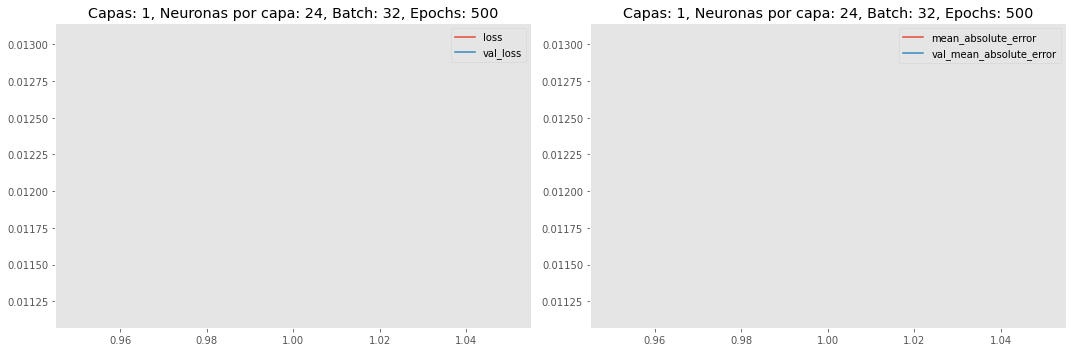

120/120 [==============================] - 8s 19ms/step - loss: 0.0130 - mean_absolute_error: 0.0130 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 2/500
 31/120 [======>.......................] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0092

KeyboardInterrupt: 

In [20]:
batch_size = 32
MAX_EPOCHS = 500
lstm_model = modelobasico( x_train_norm,y_train_norm,x_val_norm,y_val_norm,batch_size,MAX_EPOCHS)

In [ ]:
y_pred = lstm_model.predict(x_test_norm)


predicciones_LSTM = y_pred.reshape(-1, 1)

# desnormalizamos
pred_LSTM_denorm = denormalize_y_pred(predicciones_LSTM, loaded_params[salida])
y_t = y_tested
pred_LSTM_denorm = pred_LSTM_denorm.ravel()
pred_LSTM_denorm = pd.DataFrame({salida: pred_LSTM_denorm})

# y_datos_test_dn_lstm

y_t = np.array(y_t).squeeze(axis=1)
print(predicciones_LSTM.shape, y_t.shape)
pred_LSTM_denorm = np.array(pred_LSTM_denorm)
mse_LSTM = mean_squared_error(y_t, pred_LSTM_denorm)

correlacion = np.corrcoef(pred_LSTM_denorm.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_LSTM = correlacion ** 2

ns_LSTM = hydroeval.nse(y_t.reshape(-1),pred_LSTM_denorm.reshape(-1))

diff_modelo_test = np.abs(pred_LSTM_denorm.reshape(-1)-y_t.reshape(-1))     
std_LSTM = np.std(diff_modelo_test)

In [ ]:
print('LSTM')
print(f'NS test: {ns_LSTM}')
print(f'MSE test: {mse_LSTM}')
print(f'R2 test: {r_cuadrado_LSTM}')
print(f'std test: {std_LSTM}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_LSTM_denorm , label='LSTM prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
analisis_sensib_final(lstm_model,x_train_norm,y_train_norm,loaded_params,salida,ultimo_envio)

In [ ]:
modeloLR = LinearRegression()

modeloLR.fit(x_train_modelos_norm,y_train_norm)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_LR = modeloLR.predict(x_test_modelos_norm)
# desnormalizamos
pred_denorm_LR = denormalize_y_pred(y_pred_LR, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_tested
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas



##### MSE ####

mse_LR = mean_squared_error(y_t, pred_denorm_LR)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_LR.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_LR = correlacion ** 2

##### NS #####

ns_LR = hydroeval.nse(y_t.reshape(-1),pred_denorm_LR.reshape(-1))

diff_modelo_test = np.abs(pred_denorm_LR.reshape(-1)-y_t.reshape(-1))     
std_LR = np.std(diff_modelo_test)
print('LR')
print(f'NS test: {ns_LR}')
print(f'MSE test: {mse_LR}')
print(f'R2 test: {r_cuadrado_LR}')
print(f'std test: {std_LR}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_LR , label='LR prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
analisis_sensib_final(modeloLR,x_train_modelos_norm,y_train_norm,loaded_params,salida,ultimo_envio)

In [ ]:
modeloSVR = SVR()
modeloSVR.fit(x_train_modelos_norm,y_train_norm)
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_SVR = modeloSVR.predict(x_test_modelos_norm)
# desnormalizamos
pred_denorm_SVR = denormalize_y_pred(y_pred_SVR, loaded_params[salida])
###### ETIQUETAS REALES #####

y_t = y_tested
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas

##### MSE ####

mse_SVR = mean_squared_error(y_t, pred_denorm_SVR)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_SVR.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_SVR = correlacion ** 2

##### NS #####

ns_SVR = hydroeval.nse(y_t.reshape(-1),pred_denorm_SVR.reshape(-1))

diff_modelo_test = np.abs(pred_denorm_SVR.reshape(-1)-y_t.reshape(-1))     
std_SVR = np.std(diff_modelo_test)
print('SVR')
print(f'NS test: {ns_SVR}')
print(f'MSE test: {mse_SVR}')
print(f'R2 test: {r_cuadrado_SVR}')
print(f'std test: {std_SVR}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_SVR , label='SVR prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
analisis_sensib_final(modeloSVR,x_train_modelos_norm,y_train_norm,loaded_params,salida,ultimo_envio)

In [ ]:
modeloRF = RandomForestRegressor()

modeloRF.fit(x_train_modelos_norm,y_train_norm)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_RF = modeloRF.predict(x_test_modelos_norm)
# desnormalizamos
pred_denorm_RF = denormalize_y_pred(y_pred_RF, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_tested
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas




##### MSE ####

mse_RF = mean_squared_error(y_t, pred_denorm_RF)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_RF.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_RF = correlacion ** 2

##### NS #####

ns_RF = hydroeval.nse(y_t.reshape(-1),pred_denorm_RF.reshape(-1))

diff_modelo_test = np.abs(pred_denorm_RF.reshape(-1)-y_t.reshape(-1))     
std_RF = np.std(diff_modelo_test)
print('RF')
print(f'NS test: {ns_RF}')
print(f'MSE test: {mse_RF}')
print(f'R2 test: {r_cuadrado_RF}')
print(f'std test: {std_RF}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_RF , label='RF prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
analisis_sensib_final(modeloRF,x_train_modelos_norm,y_train_norm,loaded_params,salida,ultimo_envio)

In [21]:
modeloXGB = XGBRegressor()

modeloXGB.fit(x_train_modelos_norm,y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_XGB = modeloXGB.predict(x_test_modelos_norm)
# desnormalizamos
pred_denorm_XGB = denormalize_y_pred(y_pred_XGB, loaded_params[salida])

###### ETIQUETAS REALES #####

y_t = y_tested
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas




##### MSE ####

mse_XGB = mean_squared_error(y_t, pred_denorm_XGB)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_XGB.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_XGB = correlacion ** 2

##### NS #####

ns_XGB = hydroeval.nse(y_t.reshape(-1),pred_denorm_XGB.reshape(-1))

diff_modelo_test = np.abs(pred_denorm_XGB.reshape(-1)-y_t.reshape(-1))     
std_XGB = np.std(diff_modelo_test)
print('XGB')
print(f'NS test: {ns_XGB}')
print(f'MSE test: {mse_XGB}')
print(f'R2 test: {r_cuadrado_XGB}')
print(f'std test: {std_XGB}')

XGB
NS test: 0.9296420887265303
MSE test: 85.35797482976409
R2 test: 0.9307983053943089
std test: 8.097388198544184


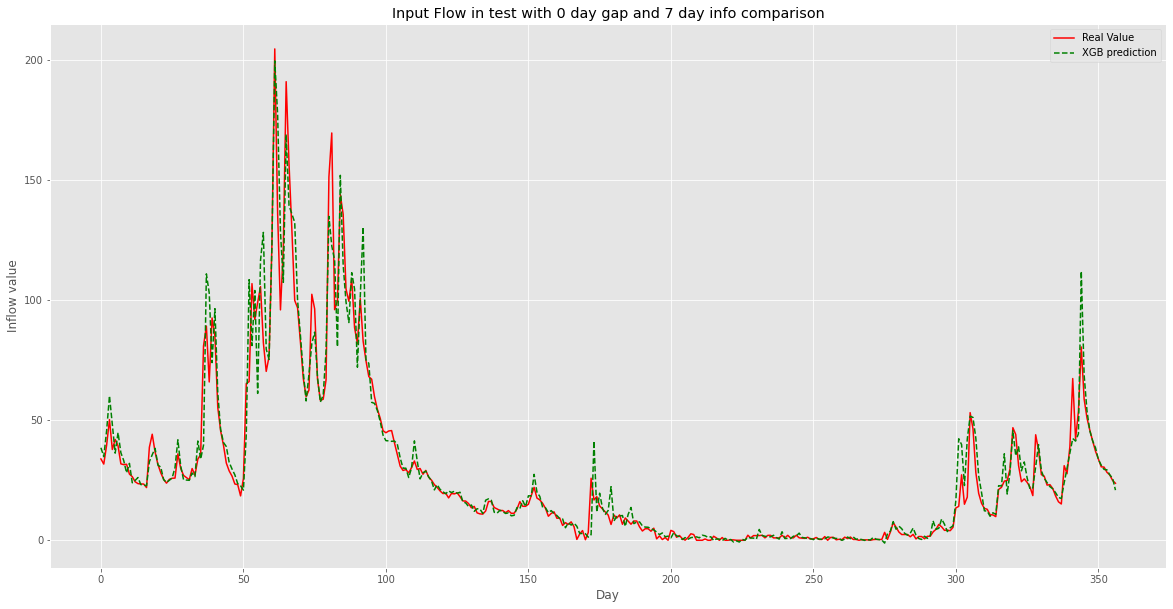

In [23]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_XGB , label='XGB prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [37]:
def plot_feature_importance(feature_importance_scores, dataset, ultimo_envio):
    # Get the feature names from the dataset
    feature_names = dataset.columns.values

    # Sort the feature importance scores in descending order
    sorted_idx = feature_importance_scores.argsort()[::-1]
    sorted_scores = feature_importance_scores[sorted_idx]

    # Ajustar el tamaño de la gráfica
    plt.figure(figsize=(15, 8))

    # Aumentar el tamaño de la fuente de los textos
    plt.xticks(range(len(sorted_scores)), feature_names[sorted_idx], rotation=270, fontsize=30) # Ajustar el tamaño de la fuente
    plt.yticks(fontsize=30)  # Ajustar el tamaño de la fuente

    # Reducir el ancho de las barras
    plt.bar(range(len(sorted_scores)), sorted_scores, width=0.2)  # Ajustar el ancho de las barras

    plt.title("Sensitivity Analysis", fontsize=30)  # Ajustar el tamaño de la fuente
    plt.xlabel("Variables", fontsize=30)  # Ajustar el tamaño de la fuente
    plt.ylabel("RMSE Variation", fontsize=30)  # Ajustar el tamaño de la fuente

    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    presente = time.time()
    if presente - ultimo_envio < 3:
        time.sleep(3 - (presente-ultimo_envio))
    bot.send_photo(idchatconbot, buffer)
    ultimo_envio = time.time()
    buffer.close()
    plt.show()
    return ultimo_envio

In [38]:
def analisis_sensib_final(modelo,x_data,y_data,norm, salida, ultimo_envio=ultimo_envio):
# parte de análisis de sensibilidad con el modelo
    # evaluate utiliza la función de pérdida definida en el modelo lstm para calcular el loss entre
    # las predicciones y la salida real
    if len(x_data.shape) == 3:
        num_features = x_data.shape[2]
    else:
        num_features = x_data.shape[1]
    try:
        baseline_score = modelo.evaluate(x_data, y_data, verbose=0)[0]
        baseline = denormalize_y_pred(baseline_score, loaded_params[salida])
        
    except AttributeError:
        baseline_score = np.mean(cross_val_score(modelo,x_data,y_data,cv=3))
        baseline = denormalize_y_pred(baseline_score, loaded_params[salida])  
    
    # Initialize an array to store the importance scores
    feature_importance_scores = np.zeros(num_features)

    # Loop through each feature
    for i in range(num_features):       
        # Evaluate devuelve el loss entre y_pred e y_true
        X_removed = x_data.copy()
        if len(X_removed.shape) == 3:
            X_removed[:,:,i] = 0
        else:
            X_removed.iloc[:,i] = 0
        try:

            sc2 = modelo.evaluate(X_removed, y_data, verbose=0)[0]
        except AttributeError:

            sc2 = np.mean(cross_val_score(modelo,X_removed,y_data,cv=3))
        
        score = denormalize_y_pred(sc2,loaded_params[salida])

        #print(f'loss desnormalizado una variable = 0: {score} loss desnormalizado todas variables: {baseline} , \nloss normalizado una variable = 0: {sc2} loss normalizado todas variables: {baseline_score} \n\n')
        # Calculate the decrease in performance
        feature_importance_scores[i] = ((score - baseline) / baseline) * 100

        # Reset the weights of the model
        if len(X_removed.shape) == 3:
            modelo.reset_states()
    
    
    mejores_5 = c.rank_five(feature_importance_scores)
    nombres = x_train_modelos.columns.tolist()
    for j, item in enumerate(mejores_5):
        mensaje_rank = f"Ranking {j+1} feature {nombres[item]} {feature_importance_scores[item]:.3f}%\n"
        print(mensaje_rank)
        #bot.send_message(idchatconbot, mensaje_rank)
    #ploteado = g.Graficas(ultimo_envio=ultimo_envio)
    ultimo_envio = plot_feature_importance(feature_importance_scores=feature_importance_scores[mejores_5], dataset= x_train_modelos,ultimo_envio=ultimo_envio)

Ranking 1 feature pred_l/m2_2dmenos1 1.279%

Ranking 2 feature Qe 1.022%

Ranking 3 feature Qemenos3 0.638%

Ranking 4 feature pred_l/m2_3dmenos3 0.605%

Ranking 5 feature Qemenos5 0.567%



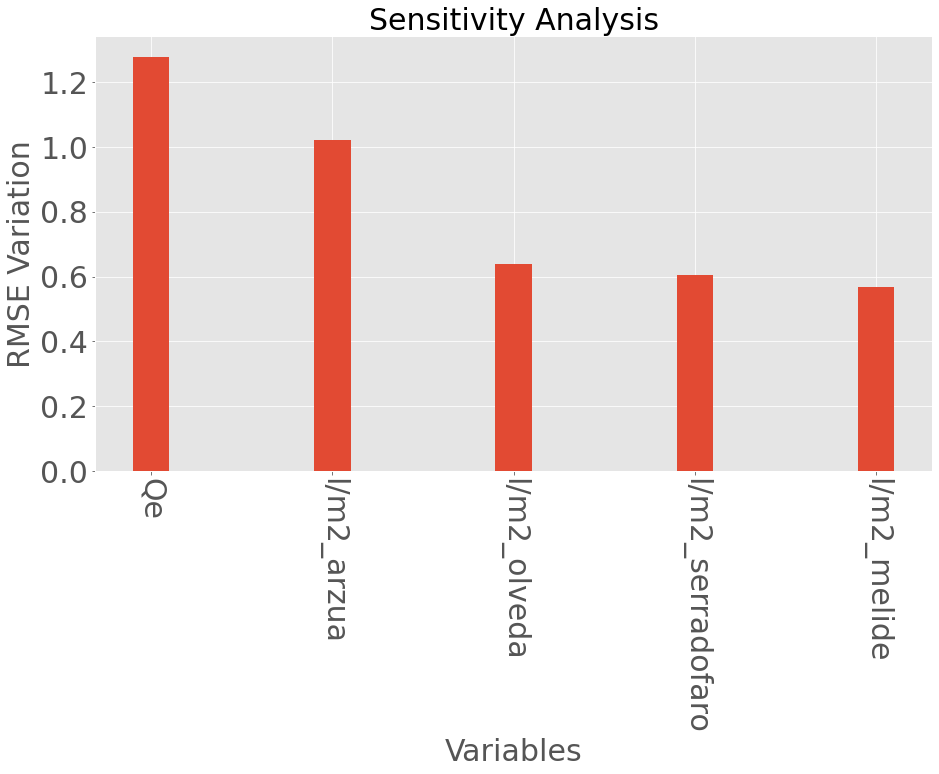

In [39]:
analisis_sensib_final(modeloXGB,x_train_modelos_norm,y_train_norm,loaded_params,salida,ultimo_envio)

In [ ]:
modeloANN = c.crear_red_ann((x_train_modelos_norm,y_train_norm),num_capas_ocultas=1,num_neuronas=24,funcion_activacion="sigmoid",regularizador=0.0001,optimizador=0.001,num_salidas=1,fn_perdida=tf.keras.losses.MeanSquaredError(),metrica=tf.keras.metrics.MeanSquaredError())


modeloANN.fit(x_train_modelos_norm,y_train_norm, epochs = MAX_EPOCHS)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_ANN = modeloANN.predict(x_test_modelos_norm)
# desnormalizamos
pred_denorm_ANN = denormalize_y_pred(y_pred_ANN, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_tested
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas



##### MSE ####

mse_ANN = mean_squared_error(y_t, pred_denorm_ANN)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_ANN.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_ANN = correlacion ** 2

##### NS #####

ns_ANN = hydroeval.nse(y_t.reshape(-1),pred_denorm_ANN.reshape(-1))

diff_modelo_test = np.abs(pred_denorm_ANN.reshape(-1)-y_t.reshape(-1))     
std_ANN = np.std(diff_modelo_test)
print('ANN')
print(f'NS test: {ns_ANN}')
print(f'MSE test: {mse_ANN}')
print(f'R2 test: {r_cuadrado_ANN}')
print(f'std test: {std_ANN}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_ANN , label='ANN prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
analisis_sensib_final(modeloANN,x_train_modelos_norm,y_train_norm,loaded_params,salida,ultimo_envio)

In [ ]:
###### PREDICCIONES #####

# para naive es simple, cojo el valor de entrada de Qe como predicción

y_pred_Naive = x_test_modelos_norm[salida].values
# desnormalizamos
pred_denorm_Naive = denormalize_y_pred(y_pred_Naive, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_tested
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas



##### MSE ####

mse_Naive = mean_squared_error(y_t, pred_denorm_Naive)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_Naive.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_Naive = correlacion ** 2

##### NS #####

ns_Naive = hydroeval.nse(y_t.reshape(-1),pred_denorm_Naive.reshape(-1))

diff_modelo_test = np.abs(pred_denorm_Naive.reshape(-1)-y_t.reshape(-1))     
std_Naive = np.std(diff_modelo_test)
print('Naive')
print(f'NS test: {ns_Naive}')
print(f'MSE test: {mse_Naive}')
print(f'R2 test: {r_cuadrado_Naive}')
print(f'std test: {std_Naive}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_Naive , label='Naive prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in test with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

# TRAIN

In [ ]:
batch_size = 32
MAX_EPOCHS = 500
lstm_model = modelobasico( x_train_norm,y_train_norm,x_val_norm,y_val_norm,batch_size,MAX_EPOCHS)

In [ ]:
y_pred = lstm_model.predict(x_train_norm)


predicciones_LSTM = y_pred.reshape(-1, 1)

# desnormalizamos
pred_LSTM_denorm = denormalize_y_pred(predicciones_LSTM, loaded_params[salida])
y_t = y_train
pred_LSTM_denorm = pred_LSTM_denorm.ravel()
pred_LSTM_denorm = pd.DataFrame({salida: pred_LSTM_denorm})

# y_datos_test_dn_lstm

y_t = np.array(y_t).squeeze(axis=1)
print(predicciones_LSTM.shape, y_t.shape)
pred_LSTM_denorm = np.array(pred_LSTM_denorm)
mse_LSTM = mean_squared_error(y_t, pred_LSTM_denorm)

correlacion = np.corrcoef(pred_LSTM_denorm.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_LSTM = correlacion ** 2

ns_LSTM = hydroeval.nse(y_t.reshape(-1),pred_LSTM_denorm.reshape(-1))

diff_modelo_train = np.abs(pred_LSTM_denorm.reshape(-1)-y_t.reshape(-1))     
std_LSTM = np.std(diff_modelo_train)

In [ ]:
print('LSTM')
print(f'NS train: {ns_LSTM}')
print(f'MSE train: {mse_LSTM}')
print(f'R2 train: {r_cuadrado_LSTM}')
print(f'std train: {std_LSTM}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_LSTM_denorm , label='LSTM prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
modeloLR = LinearRegression()

modeloLR.fit(x_train_modelos_norm,y_train_norm)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_LR = modeloLR.predict(x_train_modelos_norm)
# desnormalizamos
pred_denorm_LR = denormalize_y_pred(y_pred_LR, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_train
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas



##### MSE ####

mse_LR = mean_squared_error(y_t, pred_denorm_LR)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_LR.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_LR = correlacion ** 2

##### NS #####

ns_LR = hydroeval.nse(y_t.reshape(-1),pred_denorm_LR.reshape(-1))

diff_modelo_train = np.abs(pred_denorm_LR.reshape(-1)-y_t.reshape(-1))     
std_LR = np.std(diff_modelo_train)
print('LR')
print(f'NS train: {ns_LR}')
print(f'MSE train: {mse_LR}')
print(f'R2 train: {r_cuadrado_LR}')
print(f'std train: {std_LR}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_LR , label='LR prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
modeloSVR = SVR()
modeloSVR.fit(x_train_modelos_norm,y_train_norm)
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_SVR = modeloSVR.predict(x_train_modelos_norm)
# desnormalizamos
pred_denorm_SVR = denormalize_y_pred(y_pred_SVR, loaded_params[salida])
###### ETIQUETAS REALES #####

y_t = y_train
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas

##### MSE ####

mse_SVR = mean_squared_error(y_t, pred_denorm_SVR)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_SVR.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_SVR = correlacion ** 2

##### NS #####

ns_SVR = hydroeval.nse(y_t.reshape(-1),pred_denorm_SVR.reshape(-1))

diff_modelo_train = np.abs(pred_denorm_SVR.reshape(-1)-y_t.reshape(-1))     
std_SVR = np.std(diff_modelo_train)
print('SVR')
print(f'NS train: {ns_SVR}')
print(f'MSE train: {mse_SVR}')
print(f'R2 train: {r_cuadrado_SVR}')
print(f'std train: {std_SVR}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_SVR , label='SVR prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
modeloRF = RandomForestRegressor()

modeloRF.fit(x_train_modelos_norm,y_train_norm)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_RF = modeloRF.predict(x_train_modelos_norm)
# desnormalizamos
pred_denorm_RF = denormalize_y_pred(y_pred_RF, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_train
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas




##### MSE ####

mse_RF = mean_squared_error(y_t, pred_denorm_RF)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_RF.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_RF = correlacion ** 2

##### NS #####

ns_RF = hydroeval.nse(y_t.reshape(-1),pred_denorm_RF.reshape(-1))

diff_modelo_train = np.abs(pred_denorm_RF.reshape(-1)-y_t.reshape(-1))     
std_RF = np.std(diff_modelo_train)
print('RF')
print(f'NS train: {ns_RF}')
print(f'MSE train: {mse_RF}')
print(f'R2 train: {r_cuadrado_RF}')
print(f'std train: {std_RF}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_RF , label='RF prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
modeloXGB = XGBRegressor()

modeloXGB.fit(x_train_modelos_norm,y_train_norm)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_XGB = modeloXGB.predict(x_train_modelos_norm)
# desnormalizamos
pred_denorm_XGB = denormalize_y_pred(y_pred_XGB, loaded_params[salida])

###### ETIQUETAS REALES #####

y_t = y_train
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas




##### MSE ####

mse_XGB = mean_squared_error(y_t, pred_denorm_XGB)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_XGB.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_XGB = correlacion ** 2

##### NS #####

ns_XGB = hydroeval.nse(y_t.reshape(-1),pred_denorm_XGB.reshape(-1))

diff_modelo_train = np.abs(pred_denorm_XGB.reshape(-1)-y_t.reshape(-1))     
std_XGB = np.std(diff_modelo_train)
print('XGB')
print(f'NS train: {ns_XGB}')
print(f'MSE train: {mse_XGB}')
print(f'R2 train: {r_cuadrado_XGB}')
print(f'std train: {std_XGB}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_XGB , label='XGB prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
modeloANN = c.crear_red_ann((x_train_modelos_norm,y_train_norm),num_capas_ocultas=1,num_neuronas=24,funcion_activacion="sigmoid",regularizador=0.0001,optimizador=0.001,num_salidas=1,fn_perdida=tf.keras.losses.MeanSquaredError(),metrica=tf.keras.metrics.MeanSquaredError())


modeloANN.fit(x_train_modelos_norm,y_train_norm, epochs = MAX_EPOCHS)

In [ ]:
###### PREDICCIONES #####

# como las salidas de lstm comienzan a partir de la ventanta temporal + salida, para poder comparar el resto tengo que quitar las primeras entradas

y_pred_ANN = modeloANN.predict(x_train_modelos_norm)
# desnormalizamos
pred_denorm_ANN = denormalize_y_pred(y_pred_ANN, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_train
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas



##### MSE ####

mse_ANN = mean_squared_error(y_t, pred_denorm_ANN)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_ANN.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_ANN = correlacion ** 2

##### NS #####

ns_ANN = hydroeval.nse(y_t.reshape(-1),pred_denorm_ANN.reshape(-1))

diff_modelo_train = np.abs(pred_denorm_ANN.reshape(-1)-y_t.reshape(-1))     
std_ANN = np.std(diff_modelo_train)
print('ANN')
print(f'NS train: {ns_ANN}')
print(f'MSE train: {mse_ANN}')
print(f'R2 train: {r_cuadrado_ANN}')
print(f'std train: {std_ANN}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_ANN , label='ANN prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
x_test_modelos[salida].tail()

In [ ]:
###### PREDICCIONES #####

# para naive es simple, cojo el valor de entrada de Qe como predicción

y_pred_Naive = x_train_modelos_norm[salida].values
# desnormalizamos
pred_denorm_Naive = denormalize_y_pred(y_pred_Naive, loaded_params[salida])


###### ETIQUETAS REALES #####

y_t = y_train
# es un array de (355,1,1) le cambio el formato para que tenga el mismo que las predicciones (355,) y así poder calcular las métricas



##### MSE ####

mse_Naive = mean_squared_error(y_t, pred_denorm_Naive)


##### correlacion #####
correlacion = np.corrcoef(pred_denorm_Naive.reshape(-1),y_t.reshape(-1),rowvar=False)[0][1]
r_cuadrado_Naive = correlacion ** 2

##### NS #####

ns_Naive = hydroeval.nse(y_t.reshape(-1),pred_denorm_Naive.reshape(-1))

diff_modelo_train = np.abs(pred_denorm_Naive.reshape(-1)-y_t.reshape(-1))     
std_Naive = np.std(diff_modelo_train)
print('Naive')
print(f'NS train: {ns_Naive}')
print(f'MSE train: {mse_Naive}')
print(f'R2 train: {r_cuadrado_Naive}')
print(f'std train: {std_Naive}')

In [ ]:
# Crear un array de índices para el eje x (puede ser simplemente un rango numérico)
x_indices = np.arange(len(y_t))


# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar los valores reales (y_test)
ax.plot(x_indices, y_t, label='Real Value',  color='red',linestyle='-')

# Graficar las predicciones del modelo LSTM (y_pred_lstm)
ax.plot(x_indices, pred_denorm_Naive , label='Naive prediction', color='green', linestyle='--')

# Etiquetas de los ejes y título
ax.set_xlabel('Day')
ax.set_ylabel('Inflow value')
ax.set_title(f'Input Flow in train with {gap} day gap and {input_width} day info comparison')

# Leyenda
ax.legend()

# Mostrar la gráfica
plt.show()